In [1]:
import pandas, numpy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import altair as alt


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from tqdm import tqdm_notebook

from itertools import product, combinations

def mean_absolute_percentage_error(y_true, y_pred):
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb

# import fbprophet as Prophet


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

workspc = r'D:\projects\forecasting_practice\Forecasting_Principles_and_Practice\competition\\'

In [2]:
rain_df = pandas.read_csv(workspc + 'train_rainfall.csv')
res_df = pandas.read_csv(workspc + 'train_reservoir_levels.csv')
rain_df = rain_df.set_index(['Date'])
rain_df.index= pandas.to_datetime(rain_df.index)
res_df = res_df.set_index(['Date'])
res_df.index= pandas.to_datetime(res_df.index)
rain_df.columns = list(map(lambda x: x+'_rain', rain_df.columns))

In [3]:
master_df = res_df.join(rain_df)
master_df_diff1 = master_df.diff(axis=0, periods=1).dropna()

#splitting the data into train & test to remove any bias
#Split into train and test
train = master_df.iloc[:-365]
test  = master_df.iloc[-365:]
train_diff1 = master_df_diff1.iloc[:-365]
test_diff1= master_df_diff1.iloc[-365:]
print(len(train))
print(len(test))
print(len(train_diff1))
print(len(test_diff1))
h=365

5114
365
5113
365


In [89]:
from datetime import datetime
date_ = pandas.date_range(start=datetime(2019,1,1), end=datetime(2019,12,31))
train = master_df
test  = pandas.DataFrame(index = date_, columns = master_df.columns, data= numpy.nan)

In [7]:
from Common_Functions import *
from fbprophet import Prophet
from pmdarima.preprocessing import BoxCoxEndogTransformer, LogEndogTransformer, FourierFeaturizer


In [8]:
?pysnaive

In [9]:
def lagged_feature(ts, n=3):
    s = ts.copy()
    for i in range(n):
        s_new = ts.shift(i+1)
        s_new.name = ts.name+'_lag_'+str((i+1))
        s = pandas.concat([s, s_new], axis=1)
    s = s.fillna(method='bfill')
    return s 

In [92]:
predictions_f = dict()
predictions_f_rain = dict()
for col in res_df.columns:
    predictions_f[col] = test[[col]].copy()
    predictions_f_rain[col+'_rain'] = test[[col+'_rain']].copy()
    ### naive model
    py_snaive_fit1, py_snaive_fcast1 = pysnaive(train[col], seasonal_periods=365,forecast_horizon=h)
    predictions_f[col]["py_snaive"] = py_snaive_fcast1.values  
    
    
    py_snaive_fit1, py_snaive_fcast1 = pysnaive(train[col+'_rain'], seasonal_periods=365,forecast_horizon=h)
    predictions_f_rain[col+'_rain']["py_snaive"] = py_snaive_fcast1.values 
    
    
    ### hw model
    hw_model1 = ExponentialSmoothing(train[col],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=False)
    py_hw = hw_model1.forecast(h) + numpy.mean(hw_model1.resid)
    predictions_f[col]["py_hw"] = py_hw
    predictions_f[col]["py_hw"] = numpy.where(predictions_f[col]["py_hw"]<0, 
                                                              0.0, predictions_f[col]["py_hw"])

    hw_model1 = ExponentialSmoothing(train[col+'_rain'],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped=False).fit(use_boxcox=False)
    py_hw = hw_model1.forecast(h) + numpy.mean(hw_model1.resid)
    predictions_f_rain[col+'_rain']["py_hw"] = py_hw
    predictions_f_rain[col+'_rain']["py_hw"] = numpy.where(predictions_f_rain[col+'_rain']["py_hw"]<0, 
                                                              0.0,predictions_f_rain[col+'_rain']["py_hw"])
    
    
    ### fb prophet
    prophet_train = train[[col]].reset_index()
    prophet_train.columns = ['ds', 'y']
    fb1_model=Prophet(weekly_seasonality=True,
                       daily_seasonality=False, n_changepoints=25, seasonality_prior_scale=10, changepoint_prior_scale=1,
                       seasonality_mode="additive").fit(prophet_train)
    fb1_df=fb1_model.make_future_dataframe(h, freq='D') #set the freq argument to 'Q' for quarterly data
    fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]
    forecast = fb1_fc_df.iloc[-h:]
    predictions_f[col]["prophet"] = forecast["yhat"].values
    predictions_f[col]["prophet"] = numpy.where(predictions_f[col]["prophet"]<0, 
                                                              0.0,predictions_f[col]["prophet"])
    
    prophet_train = train[[col+'_rain']].reset_index()
    prophet_train.columns = ['ds', 'y']
    fb1_model=Prophet(weekly_seasonality=True,
                       daily_seasonality=False, n_changepoints=10, seasonality_prior_scale=1, changepoint_prior_scale=0.5,
                       seasonality_mode="additive").fit(prophet_train)
    fb1_df=fb1_model.make_future_dataframe(h, freq='D') #set the freq argument to 'Q' for quarterly data
    fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]
    forecast = fb1_fc_df.iloc[-h:]
    predictions_f_rain[col+'_rain']["prophet"] = forecast["yhat"].values
    predictions_f_rain[col+'_rain']["prophet"] = numpy.where(predictions_f_rain[col+'_rain']["prophet"]<0, 
                                                              0.0,predictions_f_rain[col+'_rain']["prophet"])
    
    
    ### Sarima Model
    _, reservoir_exog = FourierFeaturizer(m=365, k=2).fit_transform(train[col])
    _, reservoir_exog_test = FourierFeaturizer(m=365, k=2).fit_transform(train[col], n_periods=365)
    all_exog_train = pandas.concat([reservoir_exog.set_index(train[col+'_rain'].index), lagged_feature(train[col+'_rain'],n=15)], axis=1)
    
    
    
    
    Arima_without_rain_d_1= pm.auto_arima(train[col], exogenous = reservoir_exog,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=1, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)
    
    predictions_f[col]["Auto_Arima_no_rain_d1"] = Arima_without_rain_d_1.predict(n_periods=365, return_conf_int=False,
                                                                         exogenous=reservoir_exog_test)
    predictions_f[col]["Auto_Arima_no_rain_d1"] = numpy.where(predictions_f[col]["Auto_Arima_no_rain_d1"]<0, 
                                                              0.0, predictions_f[col]["Auto_Arima_no_rain_d1"])

    
    Arima_rain_d_0= pm.auto_arima(train[col+'_rain'], exogenous = reservoir_exog,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=0, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)
    
    predictions_f_rain[col+'_rain']["Auto_Arima"] = Arima_rain_d_0.predict(n_periods=365, return_conf_int=False,
                                                                         exogenous=reservoir_exog_test)
    predictions_f_rain[col+'_rain']["Auto_Arima"] = numpy.where(predictions_f_rain[col+'_rain']["Auto_Arima"]<0, 
                                                              0.0, predictions_f_rain[col+'_rain']["Auto_Arima"])

    
    
    Arima_with_rain_d_1= pm.auto_arima(train[col], exogenous = all_exog_train,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=1, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
    
    Arima_with_rain_d_0= pm.auto_arima(train[col], exogenous = all_exog_train,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=False,
                             d=0, trace=True,m=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)
    
    all_exog_test_naive = pandas.concat([reservoir_exog_test.set_index(test[col+'_rain'].index), 
                                         lagged_feature(predictions_f_rain[col+'_rain']['py_snaive'],n=15)], axis=1)
    all_exog_test_hw = pandas.concat([reservoir_exog_test.set_index(test[col+'_rain'].index), 
                                      lagged_feature(predictions_f_rain[col+'_rain']['py_hw'],n=15)], axis=1)
    all_exog_test_AR = pandas.concat([reservoir_exog_test.set_index(test[col+'_rain'].index), 
                                      lagged_feature(predictions_f_rain[col+'_rain']['Auto_Arima'],n=15)], axis=1)
    all_exog_test_FB = pandas.concat([reservoir_exog_test.set_index(test[col+'_rain'].index), 
                                      lagged_feature(predictions_f_rain[col+'_rain']['prophet'],n=15)], axis=1)


    predictions_f[col]['Arima_with_rain_d_1_sniave'] = Arima_with_rain_d_1.predict(n_periods=365, return_conf_int=False, 
                                                                        exogenous=all_exog_test_naive)
    predictions_f[col]['Arima_with_rain_d_1_hw'] = Arima_with_rain_d_1.predict(n_periods=365, return_conf_int=False, 
                                                                    exogenous=all_exog_test_hw)
    predictions_f[col]['Arima_with_rain_d_1_AR'] = Arima_with_rain_d_1.predict(n_periods=365, return_conf_int=False, 
                                                                    exogenous=all_exog_test_AR)
    predictions_f[col]['Arima_with_rain_d_1_Prophet'] = Arima_with_rain_d_1.predict(n_periods=365, return_conf_int=False, 
                                                                             exogenous=all_exog_test_FB)
    
    
    predictions_f[col]['Arima_with_rain_d_0_sniave'] = Arima_with_rain_d_0.predict(n_periods=365, return_conf_int=False, 
                                                                        exogenous=all_exog_test_naive)
    predictions_f[col]['Arima_with_rain_d_0_hw'] = Arima_with_rain_d_0.predict(n_periods=365, return_conf_int=False, 
                                                                    exogenous=all_exog_test_hw)
    predictions_f[col]['Arima_with_rain_d_0AR'] = Arima_with_rain_d_0.predict(n_periods=365, return_conf_int=False, 
                                                                    exogenous=all_exog_test_AR)
    predictions_f[col]['Arima_with_rain_d_0_Prophet'] = Arima_with_rain_d_0.predict(n_periods=365, return_conf_int=False, 
                                                                                 exogenous=all_exog_test_FB)
    
    predictions_f[col]['Arima_with_rain_d_1_sniave'] = numpy.where(predictions_f[col]['Arima_with_rain_d_1_sniave']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_1_sniave'])

    predictions_f[col]['Arima_with_rain_d_1_hw'] = numpy.where(predictions_f[col]['Arima_with_rain_d_1_hw']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_1_hw'])
    
    predictions_f[col]['Arima_with_rain_d_1_AR'] = numpy.where(predictions_f[col]['Arima_with_rain_d_1_AR']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_1_AR'])

    predictions_f[col]['Arima_with_rain_d_1_Prophet'] = numpy.where(predictions_f[col]['Arima_with_rain_d_1_Prophet']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_1_Prophet'])

    predictions_f[col]['Arima_with_rain_d_0_sniave'] = numpy.where(predictions_f[col]['Arima_with_rain_d_0_sniave']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_0_sniave'])

    predictions_f[col]['Arima_with_rain_d_0_hw'] = numpy.where(predictions_f[col]['Arima_with_rain_d_0_hw']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_0_hw'])

    predictions_f[col]['Arima_with_rain_d_0AR'] = numpy.where(predictions_f[col]['Arima_with_rain_d_0AR']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_0AR'])

    predictions_f[col]['Arima_with_rain_d_0_Prophet'] = numpy.where(predictions_f[col]['Arima_with_rain_d_0_Prophet']<0, 
                                                              0.0, predictions_f[col]['Arima_with_rain_d_0_Prophet'])


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63172.091, BIC=63224.959, Time=1.423 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=63908.014, BIC=63947.665, Time=0.355 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=63195.036, BIC=63241.295, Time=0.637 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63211.835, BIC=63258.095, Time=0.907 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=63906.017, BIC=63939.059, Time=3.094 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63166.825, BIC=63226.301, Time=2.978 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=63165.981, BIC=63218.849, Time=0.813 seconds
Fit ARIMA: (3, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=63164.940, BIC=63224.417, Time=0.827 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63071.819, BIC=63137.904, Time=8.395 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=6

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=49548.564, BIC=49707.168, Time=7.381 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=50062.218, BIC=50207.605, Time=1.125 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=49555.999, BIC=49707.994, Time=6.959 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=49562.399, BIC=49714.394, Time=9.058 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=50060.219, BIC=50198.997, Time=16.306 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=49550.561, BIC=49715.773, Time=11.573 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=49550.581, BIC=49715.793, Time=11.463 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=49548.393, BIC=49706.997, Time=10.182 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=49550.162, BIC=49715.375, Time=8.351 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=49483.471, BIC=49655.292, Time=19.880 se

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=65988.678, BIC=66153.895, Time=26.392 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=84546.645, BIC=84705.253, Time=27.454 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=60328.798, BIC=60487.406, Time=27.142 seconds
Near non-invertible roots for order (2, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=66802.601, BIC=66974.427, Time=28.063 seconds
Total fit time: 215.675 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63787.504, BIC=63840.372, Time=1.597 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=64316.897, BIC=64356.548, Time=0.337 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=63810.228, BIC=63856.487, Time=0.660 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=63787.79

In [20]:
def accuracy(y1,y2):
    
    accuracy_df=pandas.DataFrame()
    
    rms_error = numpy.round(rmse(y1, y2),4)
    
    map_error = numpy.round(MAPE(y1,y2),4)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df

In [74]:
col_list = res_df.columns


print('----model for ', col_list[0])
for model_col in predictions[col_list[0]].columns:
    print('---accuracy for ', model_col)
    print(accuracy(predictions[col_list[0]][col_list[0]],predictions[col_list[0]][model_col]))

----model for  POONDI
---accuracy for  POONDI
   %MAPE  RMSE
0    0.0   0.0
---accuracy for  py_snaive
    %MAPE      RMSE
0  85.855  649.3457
---accuracy for  py_hw
       %MAPE       RMSE
0  2298.9466  1522.3707
---accuracy for  prophet
      %MAPE      RMSE
0  113.7895  505.3331
---accuracy for  Auto_Arima_no_rain_d1
     %MAPE      RMSE
0  80.6379  567.8867
---accuracy for  Arima_with_rain_d_1_sniave
     %MAPE      RMSE
0  78.7455  554.2091
---accuracy for  Arima_with_rain_d_1_hw
     %MAPE      RMSE
0  79.8755  557.7962
---accuracy for  Arima_with_rain_d_1_AR
     %MAPE      RMSE
0  79.3931  555.6308
---accuracy for  Arima_with_rain_d_1_Prophet
     %MAPE      RMSE
0  80.5521  558.9447
---accuracy for  Arima_with_rain_d_0_sniave
      %MAPE      RMSE
0  283.6443  476.5425
---accuracy for  Arima_with_rain_d_0_hw
      %MAPE      RMSE
0  243.1851  472.9342
---accuracy for  Arima_with_rain_d_0AR
      %MAPE      RMSE
0  291.0598  486.2546
---accuracy for  Arima_with_rain_d_0_Prophet

----model for  POONDI


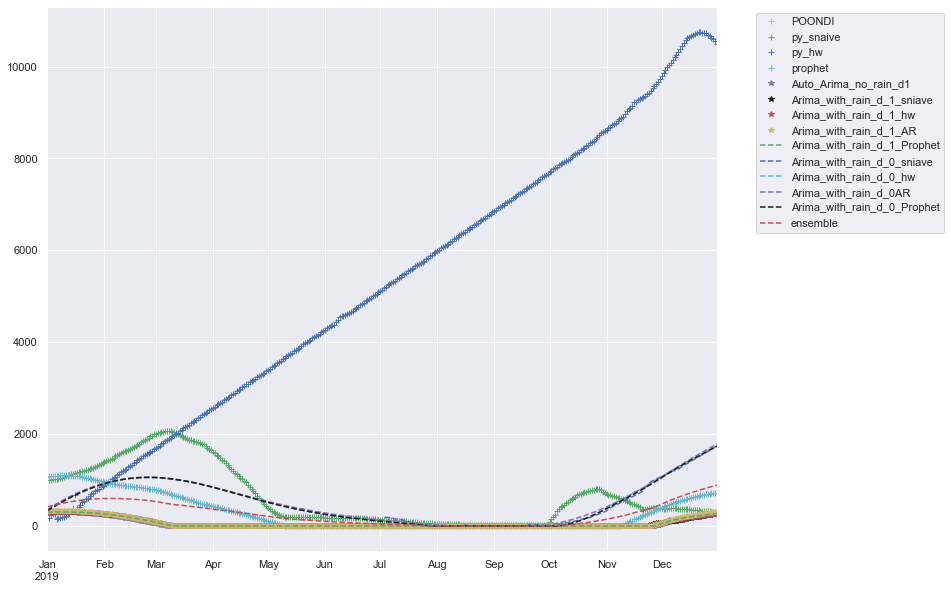

In [100]:
print('----model for ', col_list[0])
# predictions[col_list[0]][col_list[0]].plot(style="--",color="r", legend=True, label="Test")
color_list=['y','g','b','c','m','k','r','y','g','b','c','m','k','r','y']
style_list = ['+','+','+','+','*','*','*','*','--','--','--','--','--','--','*']
i=0
plt.figure(figsize=(12,10))
for model_col in predictions_f[col_list[0]].columns:
#     if(i>7):  
    predictions_f[col_list[0]][model_col].plot(style=style_list[i],color=color_list[i], legend=True, label=model_col);
    i=i+1
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))


In [101]:
col_list = res_df.columns


print('----model for ', col_list[1])
for model_col in predictions[col_list[1]].columns:
    print('---accuracy for ', model_col)
    print(accuracy(predictions[col_list[1]][col_list[1]],predictions[col_list[1]][model_col]))

----model for  CHOLAVARAM
---accuracy for  CHOLAVARAM
   %MAPE  RMSE
0    0.0   0.0
---accuracy for  py_snaive
      %MAPE      RMSE
0  516.4856  278.7878
---accuracy for  py_hw
        %MAPE       RMSE
0  13975.3049  1189.6828
---accuracy for  prophet
      %MAPE      RMSE
0  318.3315  159.2479
---accuracy for  Auto_Arima_no_rain_d1
      %MAPE      RMSE
0  929.4753  196.0358
---accuracy for  Arima_with_rain_d_1_sniave
       %MAPE     RMSE
0  1142.7609  205.765
---accuracy for  Arima_with_rain_d_1_hw
      %MAPE      RMSE
0  880.3186  194.0094
---accuracy for  Arima_with_rain_d_1_AR
      %MAPE      RMSE
0  1052.702  204.2305
---accuracy for  Arima_with_rain_d_1_Prophet
       %MAPE      RMSE
0  1022.0222  203.9606
---accuracy for  Arima_with_rain_d_0_sniave
      %MAPE      RMSE
0  575.8144  166.4999
---accuracy for  Arima_with_rain_d_0_hw
      %MAPE      RMSE
0  302.1799  158.1197
---accuracy for  Arima_with_rain_d_0AR
      %MAPE      RMSE
0  463.0162  166.4429
---accuracy for  A

----model for  CHOLAVARAM


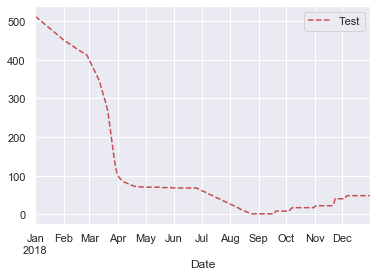

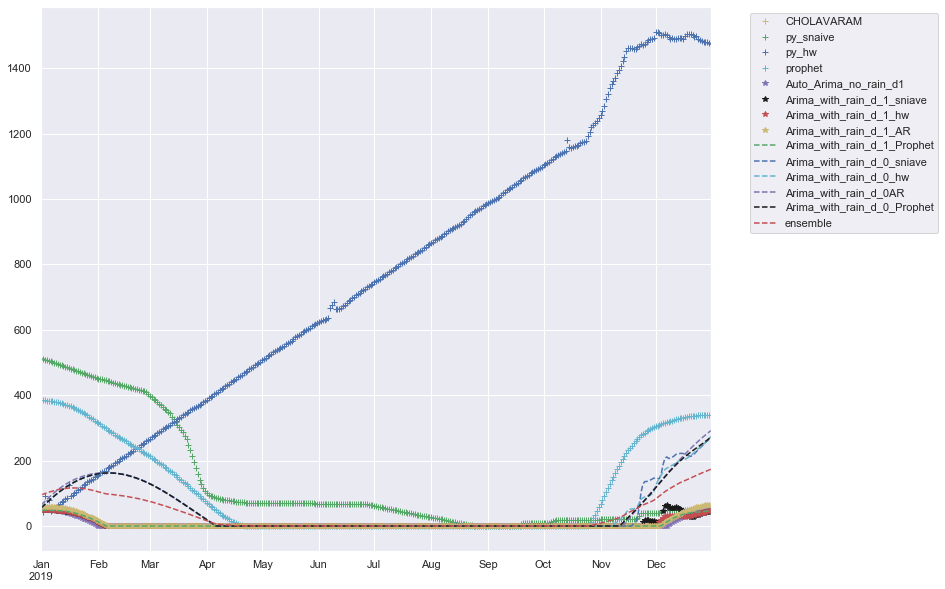

In [102]:
print('----model for ', col_list[1])
predictions[col_list[1]][col_list[1]].plot(style="--",color="r", legend=True, label="Test")
color_list=['y','g','b','c','m','k','r','y','g','b','c','m','k','r','y']
style_list = ['+','+','+','+','*','*','*','*','--','--','--','--','--','--','*']
i=0
plt.figure(figsize=(12,10))

for model_col in predictions_f[col_list[1]].columns:
    predictions_f[col_list[1]][model_col].plot(style=style_list[i],color=color_list[i], legend=True, label=model_col);
    i=i+1
    
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))

In [78]:
col_list = res_df.columns


print('----model for ', col_list[2])
for model_col in predictions[col_list[2]].columns:
    print('---accuracy for ', model_col)
    print(accuracy(predictions[col_list[2]][col_list[2]],predictions[col_list[2]][model_col]))

----model for  REDHILLS
---accuracy for  REDHILLS
   %MAPE  RMSE
0    0.0   0.0
---accuracy for  py_snaive
     %MAPE      RMSE
0  70.5897  900.4488
---accuracy for  py_hw
      %MAPE       RMSE
0  358.9868  3704.0753
---accuracy for  prophet
     %MAPE      RMSE
0  67.2064  806.0302
---accuracy for  Auto_Arima_no_rain_d1
     %MAPE      RMSE
0  29.5405  396.2637
---accuracy for  Arima_with_rain_d_1_sniave
     %MAPE      RMSE
0  29.3199  380.7896
---accuracy for  Arima_with_rain_d_1_hw
     %MAPE      RMSE
0  29.2318  381.0157
---accuracy for  Arima_with_rain_d_1_AR
     %MAPE      RMSE
0  29.4519  382.9872
---accuracy for  Arima_with_rain_d_1_Prophet
     %MAPE      RMSE
0  29.3216  384.3908
---accuracy for  Arima_with_rain_d_0_sniave
     %MAPE      RMSE
0  32.4439  518.9886
---accuracy for  Arima_with_rain_d_0_hw
     %MAPE      RMSE
0  34.1933  523.0888
---accuracy for  Arima_with_rain_d_0AR
     %MAPE      RMSE
0  33.3076  524.9882
---accuracy for  Arima_with_rain_d_0_Prophet
   

----model for  REDHILLS


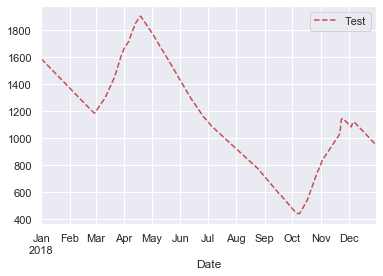

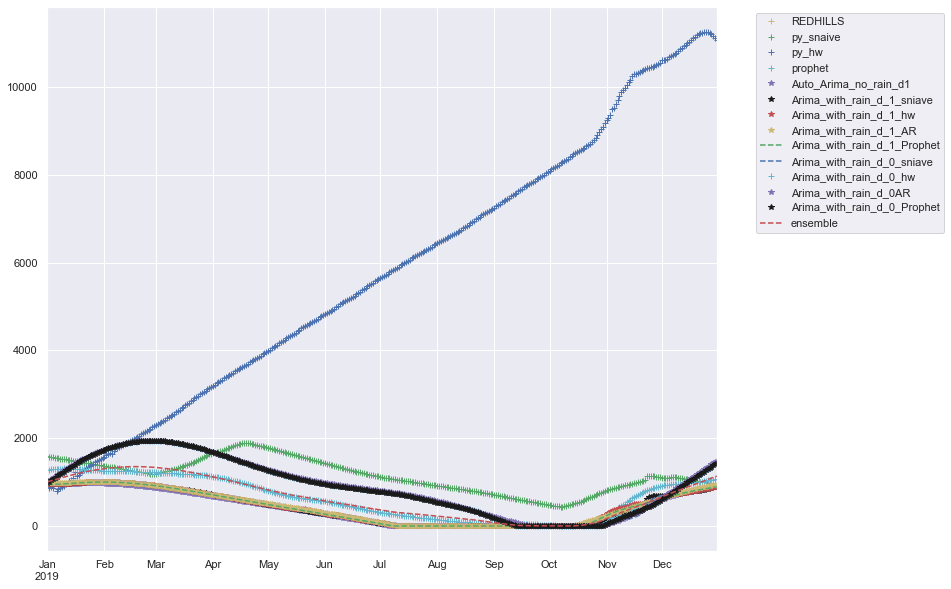

In [103]:
print('----model for ', col_list[2])
predictions[col_list[2]][col_list[2]].plot(style="--",color="r", legend=True, label="Test")
color_list=['y','g','b','c','m','k','r','y','g','b','c','m','k','r','y']
style_list = ['+','+','+','+','*','*','*','*','--','--','+','*','*','--','*']
i=0
plt.figure(figsize=(12,10))                        
for model_col in predictions_f[col_list[2]].columns:
    
    predictions_f[col_list[2]][model_col].plot(style=style_list[i],color=color_list[i], legend=True, label=model_col);
    i=i+1
                         
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))


In [61]:
col_list = res_df.columns


print('----model for ', col_list[3])
for model_col in predictions[col_list[3]].columns:
    print('---accuracy for ', model_col)
    print(accuracy(predictions[col_list[3]][col_list[3]],predictions[col_list[3]][model_col]))

----model for  CHEMBARAMBAKKAM
---accuracy for  CHEMBARAMBAKKAM
   %MAPE  RMSE
0    0.0   0.0
---accuracy for  py_snaive
      %MAPE       RMSE
0  213.7797  1014.0549
---accuracy for  py_hw
       %MAPE       RMSE
0  1035.4019  3678.7677
---accuracy for  prophet
      %MAPE      RMSE
0  130.9054  567.1186
---accuracy for  Auto_Arima_no_rain_d1
      %MAPE      RMSE
0  208.1371  697.5242
---accuracy for  Arima_with_rain_d_1_sniave
      %MAPE      RMSE
0  217.9311  730.7496
---accuracy for  Arima_with_rain_d_1_hw
      %MAPE      RMSE
0  207.4004  695.4119
---accuracy for  Arima_with_rain_d_1_AR
      %MAPE      RMSE
0  217.5257  726.6052
---accuracy for  Arima_with_rain_d_1_Prophet
      %MAPE      RMSE
0  217.4509  728.0049
---accuracy for  Arima_with_rain_d_0_sniave
     %MAPE      RMSE
0  227.494  889.8934
---accuracy for  Arima_with_rain_d_0_hw
      %MAPE      RMSE
0  216.0952  856.5918
---accuracy for  Arima_with_rain_d_0AR
     %MAPE      RMSE
0  227.225  886.2027
---accuracy fo

In [ ]:
# prophet, d1_prophet, d1_AR, d1_hw, no_rain_d1, d0_prohet, d0_AR, d0_hw

----model for  CHEMBARAMBAKKAM


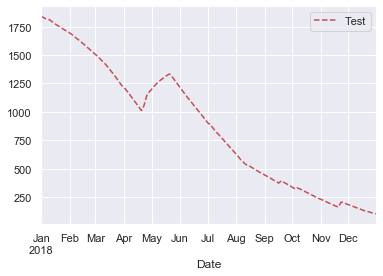

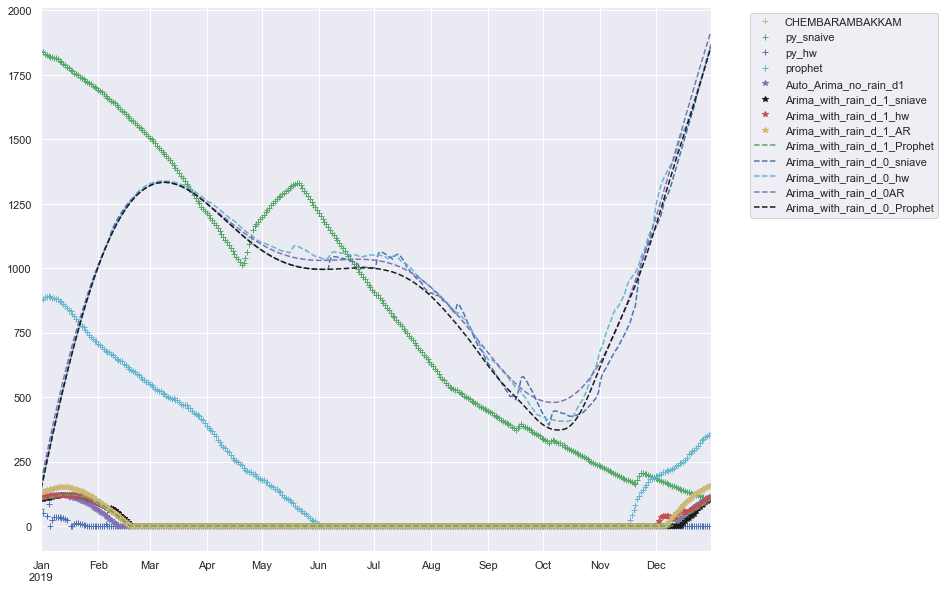

In [97]:
print('----model for ', col_list[3])
predictions[col_list[3]][col_list[3]].plot(style="--",color="r", legend=True, label="Test")
color_list=['y','g','b','c','m','k','r','y','g','b','c','m','k','r','y']
style_list = ['+','+','+','+','*','*','*','*','--','--','--','--','--','--','*']
i=0
plt.figure(figsize=(12,10))
                         
for model_col in predictions_f[col_list[3]].columns:
    predictions_f[col_list[3]][model_col].plot(style=style_list[i],color=color_list[i], legend=True, label=model_col);
    i=i+1
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))


In [15]:
_, reservoir_exog = FourierFeaturizer(m=365, k=2).fit_transform(train['POONDI'], n_periods=365)

In [16]:
reservoir_exog

,FOURIER_S365-0,FOURIER_C365-0,FOURIER_S365-1,FOURIER_C365-1
0,0.085968,0.996298,0.171300,0.985219
1,0.103105,0.994670,0.205111,0.978739
2,0.120211,0.992748,0.238679,0.971098
3,0.137282,0.990532,0.271965,0.962307
4,0.154312,0.988022,0.304928,0.952376
...,...,...,...,...
360,0.000004,1.000000,0.000007,1.000000
361,0.017217,0.999852,0.034429,0.999407
362,0.034425,0.999407,0.068810,0.997630
363,0.051623,0.998667,0.103109,0.994670


In [98]:
for col in res_df.columns:
    predictions_f[col]['ensemble'] = predictions_f[col][['prophet',
       'Auto_Arima_no_rain_d1', 'Arima_with_rain_d_1_hw', 'Arima_with_rain_d_1_AR',
       'Arima_with_rain_d_1_Prophet','Arima_with_rain_d_0_hw', 'Arima_with_rain_d_0AR',
       'Arima_with_rain_d_0_Prophet']].mean(axis=1)

In [99]:
predictions_f[col]['ensemble']

2019-01-01    226.338694
2019-01-02    239.742883
2019-01-03    254.742318
2019-01-04    267.842561
2019-01-05    281.578615
                 ...    
2019-12-27    763.405328
2019-12-28    776.096725
2019-12-29    788.152090
2019-12-30    800.034649
2019-12-31    811.633642
Freq: D, Name: ensemble, Length: 365, dtype: float64

In [104]:
for col in res_df.columns:
    predictions_f[col].to_csv(r'prediction_'+col+'_2019.csv')